<a href="https://colab.research.google.com/github/RaymundoDLC/MachineLearning/blob/main/Regresi%C3%B3n_Log%C3%ADstica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


  REPORTE DE CLASIFICACIÓN (REGRESIÓN LOGÍSTICA con Umbral=0.6)
               precision    recall  f1-score   support

No Pagado (0)       0.19      0.84      0.31       882
   Pagado (1)       0.93      0.37      0.53      5085

     accuracy                           0.44      5967
    macro avg       0.56      0.60      0.42      5967
 weighted avg       0.82      0.44      0.50      5967

Matriz de Confusión:
 [[ 739  143]
 [3207 1878]]

Recall de la Clase 'No Pagado' (0): 0.8379 (Objetivo de Negocio)
----------------------------------------------------------------------
Área Bajo la Curva (AUC): 0.6707


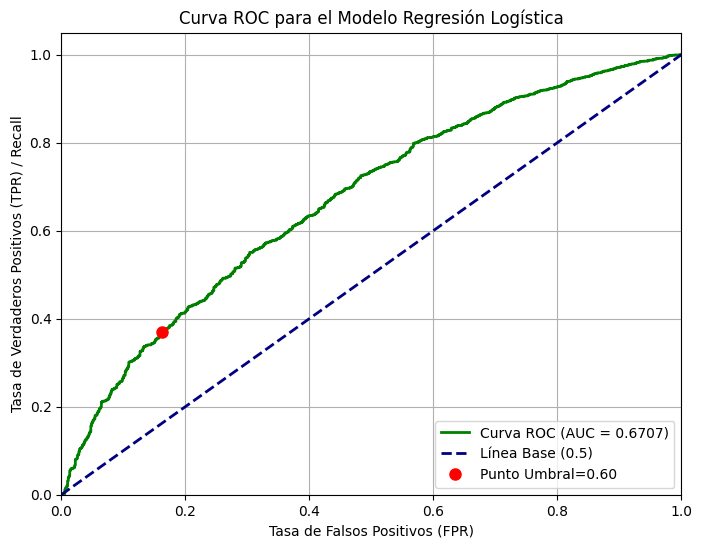

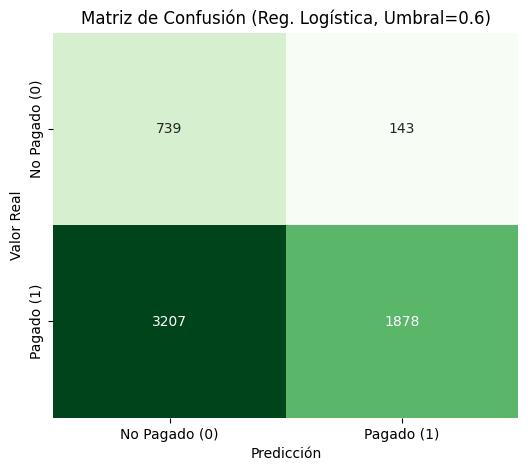

In [1]:
# ==============================================================================
# PROYECTO INTEGRADOR: MODELO REGRESIÓN LOGÍSTICA
# ==============================================================================

# --- 1. CONFIGURACIÓN E IMPORTACIONES ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression # Modelo clave
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    recall_score,
    roc_curve,
    roc_auc_score
)

# Configuración de visualización
pd.set_option('display.max_columns', None)

# --- 2. CARGA Y PREPROCESAMIENTO DE DATOS (REUSO DE LA PARTE 1) ---

# 2.1 Carga del dataset (Asumimos que el archivo .csv ha sido subido)
try:
    df = pd.read_csv('lending_club_2007_2011_6_states (1).csv')
except FileNotFoundError:
    print("Error: Asegúrate de subir el archivo CSV al entorno de Colab.")
    exit()

# 2.2 Limpieza y creación de la variable objetivo
df['repaid'] = df['loan_status'].apply(lambda status: 1 if status in ['Fully Paid'] else 0)

# 2.3 Selección, limpieza y Codificación
feature_cols = [
    'loan_amnt', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'open_acc',
    'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
    'purpose', 'grade', 'home_ownership', 'verification_status'
]
df_clean = df[df.columns.intersection(feature_cols + ['repaid'])].copy()
df_clean.dropna(inplace=True)

# Codificación One-Hot
df_dummies = pd.get_dummies(df_clean, columns=['purpose', 'home_ownership', 'verification_status'], drop_first=True)

# Codificación Ordinal de 'grade'
grade_mapping = {'A': 7, 'B': 6, 'C': 5, 'D': 4, 'E': 3, 'F': 2, 'G': 1}
df_dummies['grade_code'] = df_dummies['grade'].map(grade_mapping)
df_dummies.drop('grade', axis=1, inplace=True)

# Definición final de X e Y
X = df_dummies.drop('repaid', axis=1)
y = df_dummies['repaid']

# 2.4 División y Escalamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
scaler = StandardScaler()
numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])


# --- 3. ENTRENAMIENTO DEL MODELO REGRESIÓN LOGÍSTICA (PARTE 2) ---

# Usamos class_weight='balanced' para mitigar el desbalance de clases
# antes de ajustar el umbral de decisión, mejorando la detección de la clase minoritaria (0).
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

# Predicción de PROBABILIDADES (Necesario para el AUC y el ajuste de umbral)
# Obtenemos la probabilidad de la clase positiva (Clase 1: Pagado)
y_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

# 3.1 AJUSTE DEL UMBRAL DE DECISIÓN (CRÍTICO)
# Para priorizar el Recall de la Clase 0 (No Pagado), ajustamos el umbral a 0.6,
# tal como se reporta en su notebook adjunto.
UMBRAL_DECISION = 0.60

# Generar predicciones binarias basadas en el nuevo umbral:
# Si la probabilidad de PAGADO (Clase 1) es > 0.60, predecimos Pagado (1).
# Si la probabilidad de PAGADO (Clase 1) es <= 0.60, predecimos No Pagado (0).
y_pred_umbral = (y_proba > UMBRAL_DECISION).astype(int)


# --- 4. EVALUACIÓN Y GRÁFICOS (PARTE 3) ---

print("\n" + "="*70)
print(f"  REPORTE DE CLASIFICACIÓN (REGRESIÓN LOGÍSTICA con Umbral={UMBRAL_DECISION})")
print("="*70)

# 4.1 Reporte de Clasificación y Matriz de Confusión
print(classification_report(y_test, y_pred_umbral, target_names=['No Pagado (0)', 'Pagado (1)']))
cm = confusion_matrix(y_test, y_pred_umbral)
print("Matriz de Confusión:\n", cm)

# Métrica de Negocio Clave
recall_clase_0 = recall_score(y_test, y_pred_umbral, pos_label=0)
print(f"\nRecall de la Clase 'No Pagado' (0): {recall_clase_0:.4f} (Objetivo de Negocio)")
print("-" * 70)

# 4.2 Métricas ROC y AUC
# Calcular el Área Bajo la Curva (AUC)
# Nota: El AUC se calcula sobre las probabilidades, NO sobre las predicciones con umbral ajustado.
auc_score = roc_auc_score(y_test, y_proba)
print(f"Área Bajo la Curva (AUC): {auc_score:.4f}")

# 4.3 Generación del Gráfico de Curva ROC
# Calcular la Tasa de Verdaderos Positivos (TPR) y la Tasa de Falsos Positivos (FPR)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
# Curva ROC del modelo
plt.plot(fpr, tpr, color='green', lw=2, label=f'Curva ROC (AUC = {auc_score:.4f})')
# Línea base (modelo aleatorio)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Línea Base (0.5)')

# Añadir el punto del Umbral 0.6 para visualización
# Encontrar el índice del umbral más cercano a 0.6
idx = np.argmin(np.abs(thresholds - UMBRAL_DECISION))
plt.plot(fpr[idx], tpr[idx], 'o', color='red', markersize=8, label=f'Punto Umbral={UMBRAL_DECISION:.2f}')


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR) / Recall')
plt.title('Curva ROC para el Modelo Regresión Logística')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 4.4 Gráfico de la Matriz de Confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['No Pagado (0)', 'Pagado (1)'],
            yticklabels=['No Pagado (0)', 'Pagado (1)'])
plt.ylabel('Valor Real')
plt.xlabel('Predicción')
plt.title(f'Matriz de Confusión (Reg. Logística, Umbral={UMBRAL_DECISION})')
plt.show()